# **Workshop 3**:  Multi-Agent LLMs and Knowledge Graphs for Monitoring and Sustaining Software Systems




Date: 03 September 2025

## Introduction

Welcome to the **Multi-Agent LLMs and Knowledge Graphs for Monitoring and Sustaining Software Systems** workshop! 😺💻

In this workshop, we will explore innovative approaches to identifying, managing, and monitoring technical debt in software systems. Our focus will be threefold:

- **Multi-Agent Systems** with **Generative AI**:
We will demonstrate how specialized AI agents can collaboratively generate code, detect, refactor, and continuously monitor technical debt, enabling more resilient and maintainable software.

- **Knowledge Graphs** for **Increased Observability and Monitoring**:
We introduce the use of knowledge graphs to track code evolution, and provide a foundation for enhanced monitoring and future agentic decision support.

- **Agentic Design Patterns** for Collaboration and Optimization:
We discuss and apply agentic design patterns to obtain better agent specialization, coordination, and effectiveness in agentic systems.

### Objectives
Through the hands-on session, participants will gain practical insights into combining Generative AI, Knowledge Graphs, and applying Agentic Design Patterns to establish intelligent collaborative ecosystems for identifying and addressing technical debt in modern software ecosystems.

## Part I: Environment Setup (~30 min)
The first step is preparing our environment so everything is installed and made available for the hands-on exercises.


### Plan:
1. **Setup Environment**: Show how to run experiments on both cloud and local machine.
2. **Install Packages and Import Dependencies**: Ensure necessary and missing packages and libraries are installed and imported.
3. **Verify Setup**: Check previous installations and do test run.

### How to run?
We present two options to run the experiments below, using cloud resources and database instances or running everything locally using Docker containers and Ollama configuration. For simplicity, this workshop walkthorough will use Alternative 1.

### Alternative 1: Run on cloud - **Followed in this workshop!**

### Alternative 2: Run on local machine

1) Save the workshop directory content locally on your machine or clone the GitHub repository:

```
git clone https://github.com/adelanv/LLMA4SE-2025-Workshop3.git
```

2) Inside the directory create a *openaiapi.ini* file, add the following lines, and replace with your OpenAI API key:

```
[openai]
OPENAI_API_KEY = sk-xxxx-xxxx ...
```
Inside the notebook, you may add the following code to access your OpenAI API key:

```
import configparser

config = configparser.ConfigParser(allow_no_value = True)
config.read('openaiapi.ini')
openai_api_key = config.get('openai', 'OPENAI_API_KEY')
```

3) Install Docker Desktop on your computer, following the link: https://www.docker.com/%20products/docker-desktop/ then run Docker Desktop.

4) Open a terminal, navigate to the repository directory containing the *docker-compose.yml* file and run the following command:

```
docker-compose up -d
```

5) Run the code blocks in a Jupyter Notebook-friendly editor.


###  Install libraries & packages

Note for local run: Requires Environment with Python version > 3.10.x preinstalled.

In [5]:
!pip install neo4j
!pip install -U "autogen-agentchat" "autogen-ext[openai]" "autogen-ext[ollama]" "autogen-ext[chromadb]"
!pip install pydriller
!pip install aiohttp
!pip install nbclient

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)

   ------------- -------------------------- 1/3 [nbformat]
   -------------------------- ------------- 2/3 [nbclient]
   ---------------------------------------- 3/3 [nbclient]



### Import relevant libaries

In [6]:
import os
import re
import aiofiles
import aiohttp
import asyncio
from pathlib import Path
from datetime import datetime
from getpass import getpass
from neo4j import GraphDatabase
from autogen_ext.memory.chromadb import ChromaDBVectorMemory, PersistentChromaDBVectorMemoryConfig
from autogen_agentchat.tools import AgentTool, TeamTool
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.models.ollama import OllamaChatCompletionClient
from autogen_agentchat.conditions import TextMessageTermination, SourceMatchTermination
from autogen_agentchat.agents import AssistantAgent, CodeExecutorAgent
from autogen_ext.code_executors.jupyter import JupyterCodeExecutor
from autogen_ext.tools.code_execution import PythonCodeExecutionTool
from autogen_agentchat.teams import RoundRobinGroupChat, SelectorGroupChat
from autogen_core.model_context import BufferedChatCompletionContext, TokenLimitedChatCompletionContext, ChatCompletionContext
from autogen_core.memory import ListMemory, MemoryContent, MemoryMimeType, Memory
from autogen_agentchat.ui import Console
from autogen_agentchat.messages import BaseAgentEvent, BaseChatMessage, ModelClientStreamingChunkEvent
from autogen_core.models import UserMessage, CreateResult, SystemMessage, FunctionExecutionResultMessage, FunctionExecutionResult, ChatCompletionClient
from autogen_core.tools import BaseTool, FunctionTool, StaticStreamWorkbench, ToolResult, Workbench
from autogen_agentchat.base import Response
from autogen_agentchat.base import Handoff as HandoffBase
from autogen_core import CancellationToken, Component, ComponentModel, FunctionCall
from pydantic import BaseModel
from typing import List, Optional, Union, Sequence, Any, Callable, Dict, Mapping, AsyncGenerator

###  Prepare the model (API key and Model Configuration)

Note: Colab runs on Google’s cloud VMs, so it does not include local runtimes like Ollama (which is designed to run on your own machine, with local model weights and GPU/CPU).

**[Cloud Option]** OpenAI Model Configuration **(Chosen for workshop)**
  - max_tokens = Maximum number of tokens allowed to generate per response.
  - temperature = Controls randomness/creativity of word choice. E.g. 0.0 for deterministic answers, 1.0 for more varied and creative.
  - seed = A fixed number that makes outputs more reproducible.
  - top_p = Nucleus sampling: Another randomness control. E.g. 1.0 (use all options), or 0.9 (only top 90% likely words).

In [7]:
openai_api_key = getpass("Enter the OpenAI API key: ")

In [8]:
openai_model_client = OpenAIChatCompletionClient(
    model = "gpt-4.1",
    api_key = openai_api_key,
    temperature = None,
    seed = None,
    top_p = None,
)

openai_model_client_no_parallel_calls = OpenAIChatCompletionClient(
    model = "gpt-4.1",
    api_key = openai_api_key,
    temperature = None,
    seed = None,
    top_p = None,
    parallel_tool_calls=False,  # Must disable parallel tool calls to avoid concurrency issues in AgentTool/TeamTool
)

# Test model under different configurations and check content of response:
result = await openai_model_client.create([UserMessage(content="What is the capital of Spain?", source="user")])
result.content

'The capital of Spain is **Madrid**.'

**[Local Option]** Ollama Model Configuration

Note: Ollama must be installed on your local machine and the appropriate model pulled. Install: https://ollama.com/download


```
ollama_model_client = OllamaChatCompletionClient(
    model="qwen3:0.6b", # Try out other models e.g. llama3
)

```



### Setup Neo4J Database

1) Create a free Neo4j Aura account following the link provided: https://neo4j.com/docs/aura/classic/. This is done to obtain a free cloud-based, personal database instance for the experiments below.


  **Very important**: you should see a popup saying “Save your password now” (they only show it once). Copy the password and add it to the *auradb_password* variable below:

In [9]:
auradb_password = getpass("Enter your Neo4J Aura password: ")

2) Open the Neo4J Aura Console and navigate to *Data services/Instances*, as shown in the image below. Create a new database instance (if not automatically created), then copy the database ID. Add the ID to the *db_id* variable below:

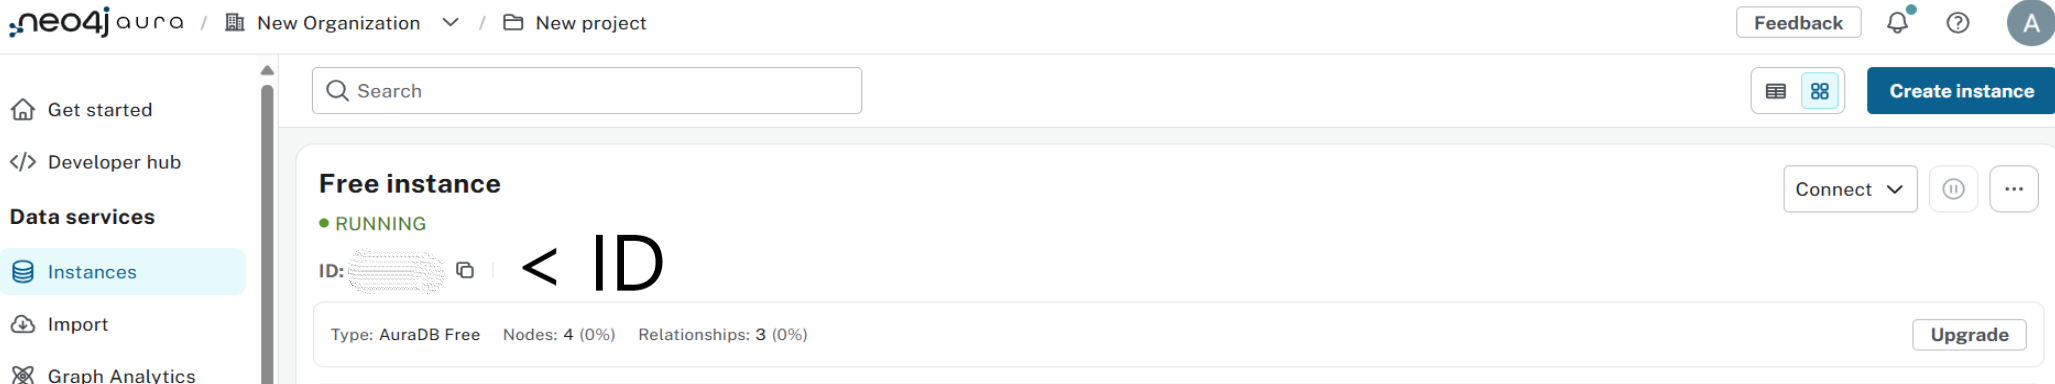

In [10]:
# Fill with the instance ID from Neo4J Aura console:
db_id = input("Enter your Aura DB ID (the xxxx part from xxxx.databases.neo4j.io): ")

# Build the full URI
uri = f"neo4j+s://{db_id}.databases.neo4j.io"

In [11]:
# Initiate Neo4J driver
driver = GraphDatabase.driver(uri, auth=("neo4j", auradb_password))

# Connectivity check:
driver.verify_connectivity()

## Part II: Background Foundations: AutoGen, Knowledge Graphs (~30 min)

### Quick Introduction to AutoGen

TODO: AutoGen Introduction - Check Hui's Slides

### Quick Introduction to Neo4J and Knowledge Graphs

TODO: Knowledge Graph Introduction

## Part III. Experimental Setup (~60 min)

### Agent Setup

#### Agentic Tool for Generating Graph Content from Agent Responses

Now, we create a function to run any Cypher query:

In [12]:
async def run_query(query: str) -> str:
    """Run a Cypher query against Neo4j and return results. Returns String representation."""
    try:
        with driver.session() as session:
            result = session.run(query)
            records = [record.data() for record in result]
        return repr(records)
    except Exception as e:
        return repr({"error": str(e)})

In [13]:
# Test running the query:
await run_query("RETURN 'I love Knowledge Graphs!' AS msg")

"[{'msg': 'I love Knowledge Graphs!'}]"

In [14]:
async def get_graph_overview() -> str:
    """Run a Cypher query against Neo4j to get full graph content and return results. Returns String representation."""
    try:
        with driver.session() as session:
            result = session.run("MATCH (n) OPTIONAL MATCH (n)-[r]-(m) RETURN n, r, m")
            records = [record.data() for record in result]
        return repr(records)
    except Exception as e:
        return repr({"error": str(e)})

In [15]:
DB_SCHEMA = """  Node Types:
                [SourceCode] with properties:
                - timestamp: date              # Current time (format: YYYY-MM-DD HH:MM:SS)
                - code: str                    # Code
                - description: str             # Short description of code functionality
                - loc: int                     # Lines of code generated
                - dependencies: List[str]      # Dependencies: e.g. imports, function calls
                - user_prompt: str             # User prompt that led to the code generated
                [TechnicalDebtItem] with properties:
                - timestamp: date              # Current time (format: YYYY-MM-DD HH:MM:SS)
                - description: List[str]       # Technical Debt Description
                - location: str                # Range of code lines affected
                Relationship Types:
                  (n:SourceCode)-[r:RefactoredTo]->(m:SourceCode)
                  (n:TechnicalDebtItem)-[:IdentifiedIn]->(m:SourceCode)"""

In [16]:
# Version 1 : One agent with access to 2 tools (get_graph_overview and run_query) - part of Team.
graph_operator_agent = AssistantAgent(
    name="graph_operator_agent",
    model_client=openai_model_client,
    tools=[get_graph_overview, run_query],
    system_message =f"""Your name is graph_operator_agent. You record agent outputs into a graph by generating **Cypher queries**.
                    Context: The graph will track code changes in time, including technical debt items (create one node per item), as identified by other agents.
                    First, you MUST call get_graph_overview to get an overview of the current graph.
                    Second, you MUST use the run_query to capture the agent outputs which are not yet recorded.
                    Rules:
                    1) Only one Cypher statement per query is allowed.
                    2) You MUST follow the schema: {DB_SCHEMA}""",
    max_tool_iterations = 5,
    reflect_on_tool_use = False,
)

In [17]:
test_task = "Current date:" + str(datetime.now()) + """ Agent 1 has generated the following code:
          def summarize_report(data: List[int]) -> Dict[str, float]:
        if not data:
            return {"count": 0, "sum": 0, "mean": None, "median": None, "stdev": None}

        return {
            "count": len(data),
            "sum": calculate_sum(data),
            "mean": statistics.mean(data),
            "median": statistics.median(data),
            "stdev": statistics.stdev(data) if len(data) > 1 else 0.0
        }
        """

await Console(graph_operator_agent.run_stream(task=test_task))

---------- TextMessage (user) ----------
Current date:2025-08-30 10:30:53.762794 Agent 1 has generated the following code:
          def summarize_report(data: List[int]) -> Dict[str, float]:
        if not data:
            return {"count": 0, "sum": 0, "mean": None, "median": None, "stdev": None}

        return {
            "count": len(data),
            "sum": calculate_sum(data),
            "mean": statistics.mean(data),
            "median": statistics.median(data),
            "stdev": statistics.stdev(data) if len(data) > 1 else 0.0
        }
        
---------- ToolCallRequestEvent (graph_operator_agent) ----------
[FunctionCall(id='call_4X2F8omHkvBYqnvcMhgyOD4Q', arguments='{}', name='get_graph_overview')]
---------- ToolCallExecutionEvent (graph_operator_agent) ----------
[FunctionExecutionResult(content='[{\'n\': {\'loc\': 9, \'code\': \'def summarize_report(data: List[int]) -> Dict[str, float]:\\n    if not data:\\n        return {"count": 0, "sum": 0, "mean": None, "me

TaskResult(messages=[TextMessage(id='3f307f4c-880f-4d61-9683-33c3d478c073', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 8, 30, 8, 30, 53, 762794, tzinfo=datetime.timezone.utc), content='Current date:2025-08-30 10:30:53.762794 Agent 1 has generated the following code:\n          def summarize_report(data: List[int]) -> Dict[str, float]:\n        if not data:\n            return {"count": 0, "sum": 0, "mean": None, "median": None, "stdev": None}\n\n        return {\n            "count": len(data),\n            "sum": calculate_sum(data),\n            "mean": statistics.mean(data),\n            "median": statistics.median(data),\n            "stdev": statistics.stdev(data) if len(data) > 1 else 0.0\n        }\n        ', type='TextMessage'), ToolCallRequestEvent(id='e51c5236-cfe1-4871-8f50-87bc04c801a8', source='graph_operator_agent', models_usage=RequestUsage(prompt_tokens=551, completion_tokens=12), metadata={}, created_at=datetime.datetime(2025, 8,

In [18]:
class ForcedAssistantAgent(AssistantAgent):
    """AssistantAgent that always enforces tool calling."""

    @classmethod
    async def _call_llm(
        cls,
        model_client: ChatCompletionClient,
        model_client_stream: bool,
        system_messages: List[SystemMessage],
        model_context: ChatCompletionContext,
        workbench: Sequence[Workbench],
        handoff_tools: List[BaseTool[Any, Any]],
        agent_name: str,
        cancellation_token: CancellationToken,
        output_content_type: type[BaseModel] | None,
        message_id: str,
    ) -> AsyncGenerator[Union[CreateResult, ModelClientStreamingChunkEvent], None]:
        """Call the language model with given context and configuration.

        Args:
            model_client: Client for model inference
            model_client_stream: Whether to stream responses
            system_messages: System messages to include
            model_context: Context containing message history
            workbench: Available workbenches
            handoff_tools: Tools for handling handoffs
            agent_name: Name of the agent
            cancellation_token: Token for cancelling operation
            output_content_type: Optional type for structured output

        Returns:
            Generator yielding model results or streaming chunks
        """
        all_messages = await model_context.get_messages()
        llm_messages = cls._get_compatible_context(model_client=model_client, messages=system_messages + all_messages)

        tools = [tool for wb in workbench for tool in await wb.list_tools()] + handoff_tools

        if model_client_stream:
            model_result: Optional[CreateResult] = None

            async for chunk in model_client.create_stream(
                llm_messages,
                tools=tools,
                tool_choice="required",   # Needs to be added to enforce tool call!
                json_output=output_content_type,
                cancellation_token=cancellation_token,
            ):
                if isinstance(chunk, CreateResult):
                    model_result = chunk
                elif isinstance(chunk, str):
                    yield ModelClientStreamingChunkEvent(content=chunk, source=agent_name, full_message_id=message_id)
                else:
                    raise RuntimeError(f"Invalid chunk type: {type(chunk)}")
            if model_result is None:
                raise RuntimeError("No final model result in streaming mode.")
            yield model_result
        else:
            model_result = await model_client.create(
                llm_messages,
                tools=tools,
                tool_choice="required", # Needs to be added to enforce tool call!
                cancellation_token=cancellation_token,
                json_output=output_content_type,
            )
            yield model_result



In [19]:
# Version 2:  Wrapping Team as Tool (via TeamTool) - Added as tool in Team members
# Note: all agents using this tool must change model config to openai_model_client_no_parallel_calls
graph_overview_agent = ForcedAssistantAgent(
    name = "graph_overview_agent",
    model_client = openai_model_client,
    tools = [get_graph_overview],
    system_message = " You MUST use the get_graph_overview tool to provide the graph content. ",
    model_context = BufferedChatCompletionContext(buffer_size=1),  # Does not need any context (save resources)
    reflect_on_tool_use = False
)

graph_operator_agent = AssistantAgent(
    name = "graph_operator_agent",
    model_client = openai_model_client,
    tools = [run_query],
    system_message = f"""Your name is graph_operator_agent. You record agent outputs into a graph by generating **Cypher queries**.
                    Context: The graph will track code changes in time, including technical debt items (create one node per item), as identified by other agents.
                    You MUST use the run_query to capture the agent outputs which are not yet recorded (overview of current graph is provided).
                    Rules:
                    1) Only one Cypher statement per query is allowed.
                    2) You MUST follow the schema: {DB_SCHEMA} """,
    max_tool_iterations = 5,
    reflect_on_tool_use = False
)

graph_operating_team = RoundRobinGroupChat(
        [graph_overview_agent, graph_operator_agent], termination_condition=SourceMatchTermination(sources=["graph_operator_agent"])
)

# Create a TeamTool that uses the team to run tasks, returning the last message as the result.
graph_tool = TeamTool(
        team=graph_operating_team,
        name="graph_operating_team",
        description="A tool for translating agent outputs to graph format.",
        return_value_as_last_message=True,
)

#### Agent Specialized in Generating Python Code from User Request

Exercises:
- Can you improve the default description and system_message:  [DEFAULT_AGENT_DESCRIPTION](https://microsoft.github.io/autogen/stable/reference/python/autogen_agentchat.agents.html#autogen_agentchat.agents.CodeExecutorAgent.DEFAULT_AGENT_DESCRIPTION) and [DEFAULT_SYSTEM_MESSAGE](https://microsoft.github.io/autogen/stable/reference/python/autogen_agentchat.agents.html#autogen_agentchat.agents.CodeExecutorAgent.DEFAULT_SYSTEM_MESSAGE)?
- Test with more complex programming tasks. What limitations can you identify?
- Check the documentation of the [CodeExecutorAgent](https://microsoft.github.io/autogen/stable/reference/python/autogen_agentchat.agents.html#autogen_agentchat.agents.CodeExecutorAgent). What other parameters can we set to achieve a more efficient agent?

In [20]:
# Agent that generates code
code_generator_agent = AssistantAgent("code_generator_agent",
                                      model_client = openai_model_client,
                                      system_message = """Your name is code_generator_agent. Your role is to generate Python code given instructions.
                                                          Provide Python code in ```python code blocks.""")

In [21]:
# Agent that generates code (monitored version)
monitored_code_generator_agent = AssistantAgent("code_generator_agent",
                                      model_client = openai_model_client_no_parallel_calls,
                                      tools=[graph_tool],
                                      system_message = """Your name is code_generator_agent. Generate Python code given instructions, then call the graph_tool (always!).
                                                          Provide Python code in ```python code blocks.
                                                          Remember to call the graph_tool to capture the generated code in graph format. """,
                                      reflect_on_tool_use = False
                                      )

In [89]:
# Test:
test_task = "Write Python code that prints Hello, Portugal!"

await Console(monitored_code_generator_agent.run_stream(task=test_task))

---------- TextMessage (user) ----------
Write Python code that prints Hello, Portugal!
---------- ToolCallRequestEvent (code_generator_agent) ----------
[FunctionCall(id='call_ijjTCHVpR2DKfnzZETk6P7JX', arguments='{"task":"Write Python code that prints Hello, Portugal!"}', name='graph_operating_team')]
---------- TextMessage (user) ----------
Write Python code that prints Hello, Portugal!
---------- ToolCallRequestEvent (graph_overview_agent) ----------
[FunctionCall(id='call_aih9I51AglTtAEnYjB9mR3SX', arguments='{}', name='get_graph_overview')]
---------- ToolCallExecutionEvent (graph_overview_agent) ----------
[FunctionExecutionResult(content='[{\'n\': {\'loc\': 9, \'code\': \'def summarize_report(data: List[int]) -> Dict[str, float]:\\n    if not data:\\n        return {"count": 0, "sum": 0, "mean": None, "median": None, "stdev": None}\\n\\n    return {\\n        "count": len(data),\\n        "sum": calculate_sum(data),\\n        "mean": statistics.mean(data),\\n        "median": s

TaskResult(messages=[TextMessage(id='12a9fb3a-050c-44c6-a030-4542b03d724d', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 8, 29, 15, 20, 35, 308975, tzinfo=datetime.timezone.utc), content='Write Python code that prints Hello, Portugal!', type='TextMessage'), ToolCallRequestEvent(id='6a92f28a-1402-468e-adf3-e835bfa99d40', source='code_generator_agent', models_usage=RequestUsage(prompt_tokens=111, completion_tokens=24), metadata={}, created_at=datetime.datetime(2025, 8, 29, 15, 20, 36, 575992, tzinfo=datetime.timezone.utc), content=[FunctionCall(id='call_ijjTCHVpR2DKfnzZETk6P7JX', arguments='{"task":"Write Python code that prints Hello, Portugal!"}', name='graph_operating_team')], type='ToolCallRequestEvent'), TextMessage(id='7d29c1f8-177b-4306-be2b-2fecdd8aaca1', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 8, 29, 15, 20, 36, 580227, tzinfo=datetime.timezone.utc), content='Write Python code that prints Hello, Portu

####  Agent Specialized in Technical Debt Detection (with Memory)

This agent is responsible for identifying technical debt in code. It will recieve a prompt consisting of a description of technical debt alongside the code to analyse and output a response containing the type, location and description of technical debt.

To improve performance we can include a list of technical debt items to look for, improving precision of non-technical llms by providing a description of each type. In addition, we can use a one shot or zero shot prompt by including examples of each type we want to look for.

How can this be improved?
  - Does the average LLM contain enough information about technical debt to accurately identify Technical debt items?
  - Would we see improvement by using a code focused LLM?
  - How could we utilize techniques such as RAG to improve this implementation?

In [22]:
# Structure the output - expected format:
class LocationRange(BaseModel):
    """Represents a code location as a line range (inclusive)."""
    start_line: int
    end_line: int

class TDIdentifierStructuredOutput(BaseModel):
    """
    Structured output for identified technical debt.
    Notes:
        - `technical_debt_types`, `descriptions`, and `locations`
          MUST always have the same length.
    """
    technical_debt_types: List[str] | None
    descriptions: List[str] | None
    location: List[LocationRange] | None

In [23]:
# Initialize memory of the agent:
tdidentifier_memory = ListMemory()

In [24]:
await tdidentifier_memory.add(MemoryContent(content="""[Duplicated code blocks] It refers to instances where the same or very similar code blocks
                                     appear in multiple locations within a software project. It can lead to maintenance challenges, as any change to the
                                     logic would need to be replicated across all instances to maintain consistency. It also increases the codebase size
                                     unnecessarily and can lead to bugs if the copies diverge over time.""", mime_type=MemoryMimeType.TEXT))

In [25]:
await tdidentifier_memory.add(MemoryContent(content="""[Nested flow statements] It refers to situations where control structures like loops or conditional
                                    statements (e.g., for, while, if-else) are placed within one another, often to several levels of depth. This nesting
                                    can lead to code that is difficult to read, understand, and maintain. It can make debugging challenging and increase the
                                     risk of errors, as understanding the logic flow becomes more complex with each added level.""", mime_type=MemoryMimeType.TEXT))

In [26]:
await tdidentifier_memory.add(MemoryContent(content=""" [Long method/Complex Class] It refers to methods or classes in software that are overly long or complex.
                                                  A method contains too many lines of code, or a class has too many responsibilities, violating principles like
                                                   Single Responsibility and leading to code that's hard to understand, maintain, and test. Such methods or
                                                    classes often encapsulate multiple functionalities, making them prone to bugs and difficult to modify. """, mime_type=MemoryMimeType.TEXT))

In [27]:
# Agent that identifies technical debt
td_identifier_agent = AssistantAgent(
    name = "technical_debt_identifier",
    model_client = openai_model_client,
    system_message = """Your name is technical_debt_identifier.
                      Your role is to identify technical and architectural debt in the provided code.""",
    output_content_type = TDIdentifierStructuredOutput,
    memory=[tdidentifier_memory]
)

In [29]:
# Agent that identifies technical debt (monitored version)
monitored_td_identifier_agent = AssistantAgent(
    name = "technical_debt_identifier",
    model_client = openai_model_client_no_parallel_calls,
    system_message = """Your name is technical_debt_identifier.
                      Your role is to identify technical and architectural debt in the provided code, then call the graph_tool (always!).
                      Remember to call the graph_tool to capture the identified technical debt in graph format. """,
    output_content_type = TDIdentifierStructuredOutput,
    memory = [tdidentifier_memory],
    reflect_on_tool_use = False,
    tools = [graph_tool],
)

In [33]:
code_content = """
def calculate_total(items):
    total = 0
    for item in items:
        total += item['price'] * item['quantity']
    return total

# TODO: Add error handling for missing keys
"""

await Console(monitored_td_identifier_agent.run_stream(task=f"Generated code: {code_content}"))

---------- TextMessage (user) ----------
Generated code: 
def calculate_total(items):
    total = 0
    for item in items:
        total += item['price'] * item['quantity']
    return total

# TODO: Add error handling for missing keys

---------- MemoryQueryEvent (technical_debt_identifier) ----------
[MemoryContent(content='[Duplicated code blocks] It refers to instances where the same or very similar code blocks\n                                     appear in multiple locations within a software project. It can lead to maintenance challenges, as any change to the\n                                     logic would need to be replicated across all instances to maintain consistency. It also increases the codebase size\n                                     unnecessarily and can lead to bugs if the copies diverge over time.', mime_type=<MemoryMimeType.TEXT: 'text/plain'>, metadata=None), MemoryContent(content='[Nested flow statements] It refers to situations where control structures like l

TaskResult(messages=[TextMessage(id='02635611-3570-4112-99bd-492168bae7f9', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 8, 30, 8, 37, 2, 470782, tzinfo=datetime.timezone.utc), content="Generated code: \ndef calculate_total(items):\n    total = 0\n    for item in items:\n        total += item['price'] * item['quantity']\n    return total\n\n# TODO: Add error handling for missing keys\n", type='TextMessage'), MemoryQueryEvent(id='a6761116-a792-4da8-b5b6-1ee3834bdb30', source='technical_debt_identifier', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 8, 30, 8, 37, 2, 473903, tzinfo=datetime.timezone.utc), content=[MemoryContent(content='[Duplicated code blocks] It refers to instances where the same or very similar code blocks\n                                     appear in multiple locations within a software project. It can lead to maintenance challenges, as any change to the\n                                     logic would need 

Examples of items that could be vectorized for rag include scientific articles, websites containing enumerations and textual definitions and examples.


Articles:
https://www.sciencedirect.com/science/article/pii/S0950584915001743

#### Agent Specialized in Giving Technical Debt Refactoring Suggestions



This agent is responsible for providing suggestions on how to resolve the technical debt. In cases where the technical debt item is more complex, say it involves multiple files, giving the refactoring agent a suggestion as input in addition to the code can improve results. Examples of these types of technical debt items are cyclic dependencies involving several files or modules.

This agent takes as input the code, in addition to the types, locations and descriptions of the previously identified technical debt items.

What types of technical debt items comes to mind when we think of higher complexity?

In [ ]:
class StructuredSuggestOutput(BaseModel):
    suggested_fix: str

In [ ]:

suggestion_agent = AssistantAgent(
    name="Technical_debt_refactoring_suggestor",
    model_client=openai_model_client,
    system_message="You are a software engineering assistant. Given a list of technical debt items, analyze each one and suggest practical, context-aware refactoring strategies to reduce complexity, improve maintainability, and align with best practices.",
    output_content_type=StructuredSuggestOutput,
)

In [ ]:
suggesting_result = await suggestion_agent.run(task=f"Suggest refactoring for this code,:\n\n{code_content} to fix these technical debts \n\n{identified_debt}. Describe how a user should perform the refactoring.")
print(result)
fix = result

#### Agent Specialized in Performing Technical Debt Refactoring

This agent focuses on refactoring recieved code. It takes as input the output of all previous agents, this being code, identified technical debt with description and location, as well as a suggestion for how to refactor the code. The output is the refactored code.

To improve this agent we can decide to use an LLM specialized in writing code.

What should be considered with this agent?
  - How can we ensure that the output of this agent is properly formatted?
      - Prompt engineering?
      - Preloading?
      - External guard rails?

The code executor intends to execute code recieved by the testing agent, to confirm that it runs.

In [ ]:
class StructuredRefactorOutput(BaseModel):
    description_of_fix: str
    refactored_code: str

In [ ]:
refactoring_agent = AssistantAgent(
    name="Technical_debt_refactoring_agent",
    model_client=openai_model_client,
    system_message="Refactor given code based on provided suggestions.",
    output_content_type=StructuredRefactorOutput,
)

In [ ]:
refactoring_agent = AssistantAgent(
    name="Technical_debt_refactoring_agent",
    model_client=openai_model_client,
    system_message="""You are responsible for refactoring code based on improvement suggestions provided by other agents.
      Your goal is to rewrite the code in a cleaner, more efficient, and maintainable way while preserving its original functionality.
      Carefully interpret the suggestions and apply them thoughtfully.
      If the suggestions are unclear or incomplete, make reasonable assumptions and proceed.
      Your output should be well-structured, readable, and ready for testing.""",
    output_content_type=StructuredRefactorOutput,
)

In [ ]:
refactoring_result = await refactoring_agent.run(task=f"Refactor this code,:\n\n{code_content} to fix this technical debt item \n\n{technical_debt_item} following this suggestion  \n\n{fix}. Provide both the description and the full code.")
print(result)

#### *(Optional)* Agent Specialized in Performing Tests

In [62]:
# Code Generator Version 1 : Generates tests and executes them

jupyter_test_executor = JupyterCodeExecutor() # Code executor class, using nbclient
# Agent that generates and executes tests 
test_generator_agent = CodeExecutorAgent(
  name = "test_generator_agent",
  code_executor = jupyter_test_executor,
  model_client = openai_model_client,
  system_message = """Your name is test_generator_agent. You generate regression/unit tests, add them to the end of the code, make them executable by calling main(), and execute the code."""
)

In [65]:
# Code Generator Version 2 : Generates tests, executes, and is monitored.

jupyter_test_executor = JupyterCodeExecutor() # Code executor class, using nbclient
execute_code = PythonCodeExecutionTool(jupyter_test_executor) # Tool that executes Python code 
# Agent that generates and executes tests (monitored version)
monitored_test_generator_agent = AssistantAgent("test_generator_agent",
                                      model_client = openai_model_client_no_parallel_calls,
                                      tools=[execute_code, graph_tool],
                                      system_message = """Your name is test_generator_agent. You generate regression/unit tests, add them to the end of the code, make them executable by calling main(), execute the code, then call the graph_tool (always!):
                                                          Remember to always call graph_tool to capture the test outcome in graph format. """
)

In [66]:
# Test:
test_task = """[Refactored code]: class DiscountPolicy:
    def __init__(self, vip_rate=0.20, regular_rate=0.10):
        self.vip_rate = vip_rate
        self.regular_rate = regular_rate

    def get_discount_rate(self, customer):
        return self.vip_rate if customer.get("is_vip", False) else self.regular_rate


class OrderCalculator:
    def __init__(self, discount_policy=None):
        self.discount_policy = discount_policy or DiscountPolicy()

    def calculate_total(self, order, customer):
        subtotal = sum(item["price"] * item["quantity"] for item in order)
        discount_rate = self.discount_policy.get_discount_rate(customer)
        return subtotal * (1 - discount_rate)"""

await jupyter_test_executor.start()
await Console(monitored_test_generator_agent.run_stream(task=test_task))
await jupyter_test_executor.stop()

---------- TextMessage (user) ----------
[Refactored code]: class DiscountPolicy:
    def __init__(self, vip_rate=0.20, regular_rate=0.10):
        self.vip_rate = vip_rate
        self.regular_rate = regular_rate

    def get_discount_rate(self, customer):
        return self.vip_rate if customer.get("is_vip", False) else self.regular_rate


class OrderCalculator:
    def __init__(self, discount_policy=None):
        self.discount_policy = discount_policy or DiscountPolicy()

    def calculate_total(self, order, customer):
        subtotal = sum(item["price"] * item["quantity"] for item in order)
        discount_rate = self.discount_policy.get_discount_rate(customer)
        return subtotal * (1 - discount_rate)
---------- ToolCallRequestEvent (test_generator_agent) ----------
[FunctionCall(id='call_vyEX8XgzUvTUNtCE3Ux8nh1z', arguments='{"code":"class DiscountPolicy:\\n    def __init__(self, vip_rate=0.20, regular_rate=0.10):\\n        self.vip_rate = vip_rate\\n        self.regular_

For simplicity this agent will recieve a simple prompt asking it to evaluate the code created by the previous agents. Other possibilites include performing static analysis of the code by using tool calls in the testing agent, as well as by allowing it to call the CodeExecutor mentioned in the introductory section.

Tasks:

 - Modify the prompt to Improve the output.
    - How concise is the default response?
    - Does it contain unneccessary information?
    - Remember that the test output should be read by both humans and LLMs.

  - Are there other modifications you could make to improve the agent?
    - Output format?
    - Hyperparameters?
      - How much temperature would we want in this case?


In [ ]:
class StructuredTestOutput(BaseModel):
    evaluation: str
    accepted: str

In [ ]:
test_agent = AssistantAgent(
    name="Test_agent",
    model_client=openai_model_client,
    system_message="Evaluate the given code. Provide feedback on whether the refactoring was successful or if further changes are needed.",
     output_content_type=StructuredTestOutput,
)

In [ ]:
##Code for validating JSON structure in output from

def validate_json_structure(data: dict) -> None:
    """
    Validate the structure of the JSON data.

    Args:
        data (dict): The JSON data to validate

    Raises:
        JSONValidationError: If the JSON structure is invalid
    """
    if not isinstance(data, dict):
        raise Exception("Root element must be a dictionary")

    for commit_hash, entries in data.items():
        if not isinstance(entries, list):
            raise Exception(f"Entries for commit {commit_hash} must be a list")

        for entry in entries:
            if not isinstance(entry, dict):
                raise Exception(f"Each entry in commit {commit_hash} must be a dictionary")

            if 'technicalDebts' in entry and not isinstance(entry['technicalDebts'], list):
                raise Exception(f"technicalDebts in commit {commit_hash} must be a list")

### Team Setup

Now we can create a selector group chat, to allow for more complex interactions between agents.

Here, a selector agent will be created to allow for the code to be analysed until it has passed a test. The selector will make a choice depending on the output of th test agent, and will either pass the refactored code further or make the refactoring agent attempt another refactoring with further information from the test agent.

The selector agent is a higher level API from the autogen library, and we could have implemented similar functionality by using other parts of the framework for a more custom solution.
  - What would you change from this approach?
  - What are the possible areas where the groupchat could fail?
      - How would temperature affect the chat?
  - In this example we use a candidate function to follow a predetermined flow. Would a less deterministic selection prompt be beneficial? Would a high or low temperature be most beneficial for this?

In [ ]:
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.teams import SelectorGroupChat
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination
from autogen_agentchat.messages import BaseAgentEvent, BaseChatMessage
from typing import List, Sequence
#from autogen_agentchat import GroupChatManager


text_mention_termination = TextMentionTermination("TERMINATE")
max_messages_termination = MaxMessageTermination(max_messages=25)
termination = text_mention_termination | max_messages_termination

#model_client = OllamaChatCompletionClient(model="qwen3:0.6b")
model_client = openai_model_client


planning_agent = AssistantAgent(
    "PlanningAgent",
    description="An agent for planning tasks, this agent should be the first to engage when given a new task.",
    model_client=model_client,
    system_message="""
    You are a planning agent.
    Your job is to break down complex tasks into smaller, manageable subtasks.
    Your team members are:
      Technical_debt_identifier: Identifies technical debt
      Technical_debt_refactoring_suggestor: Creates suggestions for fixing identified technical debt
      Technical_debt_refactoring_agent: Refactors code based on suggestions from the suggestor agent or feedback from the test agent
      Test_agent: Analyses refactored code and decides whether or not it is approved.


    You only plan and delegate tasks - you do not execute them yourself.

    When assigning tasks, use this format:
    1. <agent> : <task>

    After all tasks are complete, summarize the findings and end with "TERMINATE".
    """,
)

selector_prompt = """You are coordinating a multi-agent workflow focused on identifying and resolving technical debt.

Agent roles:
{roles}

Conversation history:
{history}

Based on the above context, select the most appropriate agent from {participants} to perform the next step in the workflow.

Important:
- Ensure that the Technical_debt_identifier has initiated the process before others proceed.
- Follow the logical sequence: identification → suggestion → refactoring → testing → approval.
- Only one agent should be selected at a time.

Choose the agent best positioned to advance the current task.
"""

# Create the group chat
team = SelectorGroupChat(
    [planning_agent, debt_agent, suggestion_agent, refactoring_agent, test_agent],
    model_client=model_client,
    selector_prompt=selector_prompt,  # Default model-based selector,
    allow_repeated_speaker=True,
    termination_condition=termination
)
task = f"Analyze the following code and identify technical debt:\n\n{code_content}. Then suggest a refactoring strategy and refactor the code."
await Console(team.run_stream(task=task))

#manager = GroupChatManager(groupchat=group_chat)

# Entry point
#user_proxy = UserProxyAgent(name="User", code_execution_config=False)

# Start the chat
#user_proxy.initiate_chat(
#    manager,
#    message="Here's a piece of code. Can you help me review and improve it?"
#)

In [ ]:
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.teams import SelectorGroupChat
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination
from autogen_agentchat.messages import BaseAgentEvent, BaseChatMessage
from typing import List, Sequence
#from autogen_agentchat import GroupChatManager


text_mention_termination = TextMentionTermination("TERMINATE")
max_messages_termination = MaxMessageTermination(max_messages=25)
termination = text_mention_termination | max_messages_termination

model_client = OllamaChatCompletionClient(model="qwen3:0.6b")
# Add openai client

#Selector prompt not used in current version (candidate_func is used instead)
selector_prompt = """You are coordinating a multi-agent workflow focused on identifying and resolving technical debt.

Agent roles:
{roles}

Conversation history:
{history}

Based on the above context, select the most appropriate agent from {participants} to perform the next step in the workflow.

Important:
- Ensure that the Technical_debt_identifier has initiated the process before others proceed.
- Follow the logical sequence: identification → suggestion → refactoring → testing → approval.
- Only one agent should be selected at a time.

Choose the agent best positioned to advance the current task.
"""

# Candidate function to narrow down eligible agents#
#def candidate_func(messages: List[BaseChatMessage], agents: List[AssistantAgent]) -> List[AssistantAgent]:
def candidate_func(messages: Sequence[BaseAgentEvent | BaseChatMessage]) -> List[str]:
    last_msg = messages[-1]
    last_sender = messages[-1].source


    if last_sender == "user":
        return [debt_agent.name]
    if last_sender == "Technical_debt_identifier":
        return [suggestion_agent.name]
    elif last_sender == "Technical_debt_refactoring_suggestor":
        return [refactoring_agent.name]
    elif last_sender == "Technical_debt_refactoring_agent":
        return [test_agent.name]
    elif last_sender == "Test_agent":
        print("-------------------> last msg",last_msg)
        if "approved" in last_msg.accepted or "looks good" in last_msg.accepted or "yes" in last_msg.accepted:
            return []  # Terminate
        else:
            return [refactoring_agent.name]  # Loop back for improvements
    return agents  # Default fallback

def candidate_func_adapter(thread) -> List[AssistantAgent]:
    print(thread)
    return candidate_func(thread.messages, thread.agents)


# Create the group chat
team = SelectorGroupChat(
    [debt_agent, suggestion_agent, refactoring_agent, test_agent],
    model_client=model_client,
    #selector=WorkflowSelector(),
    termination_condition=termination,
    candidate_func=candidate_func,
)
# Create the group chat
#group_chat = SelectorGroupChat(
#    agents=[reviewer, fixer, tester],
#    selector=select_speaker,  # Default model-based selector
#    candidate_func=candidate_func,
#    allow_repeat_speaker=False
#)
task = f"Analyze the following code and identify technical debt:\n\n{code_content}. Then suggest a refactoring strategy and refactor the code."
await Console(team.run_stream(task=task))

#manager = GroupChatManager(groupchat=group_chat)

# Entry point
#user_proxy = UserProxyAgent(name="User", code_execution_config=False)

# Start the chat
#user_proxy.initiate_chat(
#    manager,
#    message="Here's a piece of code. Can you help me review and improve it?"
#)

## Part III. Task Resolution via Agentic Tool (~30 min)


### Experiments

## Ignore below


In [ ]:
code_folder = "codebase"
os.makedirs(code_folder, exist_ok=True)

sample_file_path = os.path.join(code_folder, "example.py")
with open(sample_file_path, "w") as f:
    f.write("""
def calculate_total(items):
    total = 0
    for item in items:
        total += item['price'] * item['quantity']
    return total

# TODO: Add error handling for missing keys
""")

with open(sample_file_path, "r") as f:
    code_content = f.read()

print(code_content)

In [ ]:
# TODO : SEE WHAT WE DO WITH THIS - MAYBE ALSO ALLOW USER TO CHOOSE BETWEEN GENERATING CODE OR ADDING EXISTING REPO CONTENT

from pydriller import Repository

def analyze_modifications(commit, debts, debts_file, repo_url):
    """
    The function will go thorugh each commit in the repository and analyze.

    """
    for modification in commit.modified_files:
        if not modification.source_code or not is_source_code(modification.new_path):
            continue

        print("Analyzing file: %s", modification.new_path)
        enumerated_content = enumerate_file(modification.source_code)
        #Pass to starting point of agent interaction

def analyze_commits(repo_url, begin_commit, end_commit, debts, debts_file):
    """
    The function will iterate through the commits and fetch the changed content from the previous commit.

    """
    commit_count = 0
    for commit in Repository(repo_url, from_commit=begin_commit, to_commit=end_commit).traverse_commits():
        print("Analyzing commit: %s", commit.hash)
        print("In the repo: %s", repo_url)
        commit_count += 1

        analyze_modifications(commit, debts, debts_file, repo_url)

In [ ]:
class SimpleDocumentIndexer:
    """Basic document indexer for AutoGen Memory."""

    def __init__(self, memory: Memory, chunk_size: int = 1500) -> None:
        self.memory = memory
        self.chunk_size = chunk_size

    async def _fetch_content(self, source: str) -> str:
        """Fetch content from URL or file."""
        if source.startswith(("http://", "https://")):
            async with aiohttp.ClientSession() as session:
                async with session.get(source) as response:
                    return await response.text()
        else:
            async with aiofiles.open(source, "r", encoding="utf-8") as f:
                return await f.read()

    def _strip_html(self, text: str) -> str:
        """Remove HTML tags and normalize whitespace."""
        text = re.sub(r"<[^>]*>", " ", text)
        text = re.sub(r"\s+", " ", text)
        return text.strip()

    def _split_text(self, text: str) -> List[str]:
        """Split text into fixed-size chunks."""
        chunks: list[str] = []
        # Just split text into fixed-size chunks
        for i in range(0, len(text), self.chunk_size):
            chunk = text[i : i + self.chunk_size]
            chunks.append(chunk.strip())
        return chunks

    async def index_documents(self, sources: List[str]) -> int:
        """Index documents into memory."""
        total_chunks = 0

        for source in sources:
            try:
                content = await self._fetch_content(source)

                # Strip HTML if content appears to be HTML
                if "<" in content and ">" in content:
                    content = self._strip_html(content)

                chunks = self._split_text(content)

                for i, chunk in enumerate(chunks):
                    await self.memory.add(
                        MemoryContent(
                            content=chunk, mime_type=MemoryMimeType.TEXT, metadata={"source": source, "chunk_index": i}
                        )
                    )

                total_chunks += len(chunks)

            except Exception as e:
                print(f"Error indexing {source}: {str(e)}")

        return total_chunks

In [ ]:
# Initialize vector memory
rag_memory = ChromaDBVectorMemory(
    config=PersistentChromaDBVectorMemoryConfig(
        collection_name="technical_debt_docs",
        persistence_path=os.path.join(str(Path.home()), ".chromadb_autogen"),
        k=3,                  # Return top 3 results
        score_threshold=0.4,  # Minimum similarity score
    )
)

await rag_memory.clear()  # Clear existing memory


# Index AutoGen documentation
async def index_autogen_docs() -> None:
    indexer = SimpleDocumentIndexer(memory=rag_memory)
    sources = [
        "https://www.sciencedirect.com/science/article/pii/S0950584915001743",
    ]
    chunks: int = await indexer.index_documents(sources)
    print(f"Indexed {chunks} chunks from {len(sources)} AutoGen documents")


await index_autogen_docs()

 **Duplicated code blocks**                      It refers to instances where the same or very similar code blocks appear in multiple locations within a software project. It can lead to maintenance challenges, as any change to the logic would need to be replicated across all instances to maintain consistency. It also increases the codebase size unnecessarily and can lead to bugs if the copies diverge over time. Refactoring to remove duplicated code, often by creating shared functions or classes, can reduce this debt, improving maintainability and reducing the potential for errors.

  **Nested flow statements**                      It refers to situations where control structures like loops or conditional statements (e.g., for, while, if-else) are placed within one another, often to several levels of depth. This nesting can lead to code that is difficult to read, understand, and maintain. It can make debugging challenging and increase the risk of errors, as understanding the logic flow becomes more complex with each added level. Minimizing the depth of nesting improves code readability and maintainability, thereby reducing technical debt.    

 **Collapsible "if" statements**                 It refers to scenarios where multiple sequential "if" statements are nested inside the other but could be combined into a more streamlined and efficient conditional structure. This nesting often occurs when different conditions are checked in a series of "if" statements, which can be simplified by using logical operators (AND, OR) to combine these conditions into a single "if" statement. Reducing the number of nested "if" statements can enhance code readability and maintainability and reduce complexity.  
                             
 **Long method/Complex Class**                  It refers to methods or classes in software that are overly long or complex. A method contains too many lines of code, or a class has too many responsibilities, violating principles like Single Responsibility and leading to code that's hard to understand, maintain, and test. Such methods or classes often encapsulate multiple functionalities, making them prone to bugs and difficult to modify. Simplifying these methods or breaking down complex classes into smaller, more cohesive units can enhance code readability and maintainability.  |

In [ ]:
# Code Generator Version 2 : Generates code, but executes on demand
# Code executor class, executes code using nbclient
jupyter_code_executor = JupyterCodeExecutor()

# Tool that executes Python code in a code executor and returns output.
execute_code = PythonCodeExecutionTool(jupyter_code_executor)

# Agent that generates code, and can use tool to execute it, if requested.
code_generator_agent = AssistantAgent("code_generator_agent",
                                      model_client = openai_model_client,
                                      tools=[execute_code],
                                      system_message = """Your name is code_generator_agent.
                                                          Your role is to generate Python code and shell scripts based on user instructions.
                                                          Python code should be provided in ```python code blocks, and sh shell scripts should be provided in ```sh code blocks for execution.
                                                          You are also able to execute code using the execute_code tool. Only execute code if requested. """)